In [1]:
import sys
sys.path.append('../')
sys.dont_write_bytecode = True
import numpy as np
from matplotlib.pyplot import *
%matplotlib inline
import numba
sys.path.append('/Users/Michael_Saha/Repositories/')
sys.path.append('./../../../')
from fire_sim import *

(array([  2.70000000e+01,   5.46000000e+02,   4.49300000e+03,
          1.74820000e+04,   3.31420000e+04,   2.91900000e+04,
          1.24550000e+04,   2.40400000e+03,   2.47000000e+02,
          1.40000000e+01]),
 array([-4.31612947, -3.42454834, -2.5329672 , -1.64138606, -0.74980492,
         0.14177621,  1.03335735,  1.92493849,  2.81651963,  3.70810077,
         4.5996819 ]),
 <a list of 1 Patch objects>)

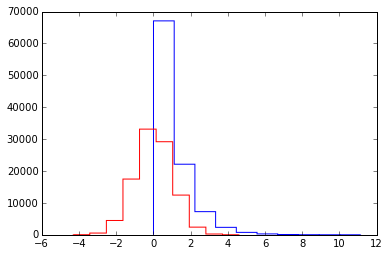

In [16]:
g = parameterize(np.random.gamma,1,1)
n = parameterize(np.random.normal,0,1)


hist(g(100000),histtype='step')
hist(n(100000),histtype='step',color='r')

### Fire Simulation
#### Variable Descriptions
```fires``` - The coordinates of all fires that have burnt. A 2-tuple of $(y,x)$ coordinates.

```active``` - A 'cursor' that shows the range of pixels that are currently burning. This will be a contiguous range, as the active pixels will be visited in linear order. Simulation invariant: ```active[1]``` is the total number of fires that have started in the whole simulation. The $(y,x)$ coordinates all fires after the simulation has run is: ```(fires[0][:active[1]], fires[1][:active[1]])```

```B``` - The 2d map of biomes. Each biome is associated with a distribution of land covers. For example, a chapparal biome would have more shrub land cover and a defensible space biome would have more inflammable land cover.

```L``` - The 2d map of land cover types {e.g. inflammable, grass, shrub}. Each land cover type has burn properties that are drawn from a land-cover specific distribution. Land cover type 0 is inflammable; it will not burn, accumulate energy, or release energy.

```E``` - The 2d accumulated energy. This is the matrix where, after a nearby pixel has burned and transmitted its energy to a neighborhood, the energy is stored/tallied. This builds up over the whole course of the simulation (never decays temporally).

```A``` - The 2d map of energies required ignite a cell. When ```E[i,j]``` exceeds ```A[i,j]```, then a fire ignites in the cell.

```R``` - 2d map of energy released. When cell $(i,j)$ is ignited, the energy value in ```R[i,j]``` is distributed among neighbors such that the total energy distributed is equal to ```R[i,j]```. The energy distributed to a givel pixel $p_{k,l}$ is equal to $\frac{R_{i,j}}{d^{2}}$, where $d$ is the Euclidean distance from pixel $(i,j)$ to pixel $(k,l)$.

```F``` - The 2d map of all fires that have burnt. The pixel value at ```F[i,j]``` is a integer value indicating the iteration on which the pixel first exceeded the ```A[i,j]```. If ```F[i,j]``` is ```0```, then the pixel has not been burnt. 


In [20]:
landcover_components = (
# p(Bare)   p(Grass)  p(Shrub)
( 1.00,      0.00,     0.00    ), # Inflammable
( 0.50,      0.45,     0.05    ), # Defensible Space
( 0.10,      0.20,     0.70    )) # Chaparral


distr_of_A = np.random.gamma
distr_of_R = np.random.gamma

#          #------BARE-----#   #---GRASS--#   #---SHRUB---#
A_params = ((np.nan, np.nan), (0.53, 3.01),   (1.50, 0.50))
R_params = ((np.nan, np.nan), (1.00, 0.10),   (4.50, 1.40))

R_distr = [parameterize(distr_of_R, *R_params[b]) for b in range(N_BIOMES)]
        
A_distr = [parameterize(distr_of_A, *A_params[b]) for b in range(N_BIOMES)]

grid_dims = (100,100)
cell_size_m = 10  # meters

B = np.zeros(shape=grid_dims,dtype=int)
B[int(grid_dims[0]/3):int(2*grid_dims[0]/3)] = 1
B[int(2*grid_dims[0]/3):] = 2

L = np.zeros_like(B,dtype=int)
E = np.zeros_like(B,dtype=float)
A = np.zeros_like(B,dtype=float)
R = np.zeros_like(B,dtype=float)
F = np.zeros_like(B,dtype=bool)

fill_L(B, landcover_components, L)
E[L == 0] = np.nan
fill_A(L, A_distr, A)
fill_R(L, R_distr, R)

active = np.zeros(2, dtype=int)
ignitions = np.array([0]), np.array([0])
fires = np.zeros(B.size, dtype=int), np.zeros(B.size, dtype=int)
ignite_fires(ignitions, fires, active, L, F)

0

In [ ]:
GRASS = 1
SHRUB = 2

def valid_parameters(A_params, R_params):
    """Evaluate the parameters w.r.t. the biophysical contraints.
    
    Ex. 1: The mean energy released by shrubs should exceed the mean
    energy released by grasses.
    
    Ex. 2: The mean energy required to ignite shrubs should exceed
    the same amount of energy required to ignite grasses.
    """
    return (A_params[SHRUB][0] > A_parames[GRASS][0] and 
            A_params[SHRUB][1] > A_parames[GRASS][1] and
            R_params[SHRUB][0] > R_params[GRASS][0] and
            R_params[SHRUB][1] > R_params[GRASS][1])

In [ ]:
# @property
# def params(self, A_params, R_params):
#     return self.A_params, self.R_params

# @params.setter
# def params(self,A_R_params):
#     self.A_params, self.R_params = A_R_params
#     self.reparameterize()

# def reparameterize(self):
#     """Reparameterize the distributions based on current parameters."""
#     self.R_distr = [parameterize_distr(self.distr_of_A, *self.R_params[b])
#                     for b in range(self.N_BIOMES)]
    
#     self.A_distr = [parameterize_distr(self.distr_of_B, *self.A_params[b])
#                     for b in range(self.N_BIOMES)]

In [ ]:
"""A fire simulation."""
class Simulation:
    def __init__(self, B, landcover_distr, A_distr, R_distr):
        """Instantiate the simulation with a Biome map and landcover,
        A and R distributions."""
        
        # Environmental Fields
        self.B = B.copy()
        self._N_BIOMES = len(landscover_distr)
        self._N_LANDCOVERS = len(distr_of_A)
        self.landcover_distr = landcover_distr
        self.A_distr = A_distr
        self.R_distr = R_distr
        self.L = np.zeros_like(B, dtype=int)
        
        # 'Energy' Fields
        self.E = np.zeros_like(B, dtype=float)
        self.A = np.zeros_like(B, dtype=float)
        self.R = np.zeros_like(B, dtype=float)
        self.F = np.zeros_like(B, dtype=int)
        
        # Fires
        self.fires = np.zeros(shape=(B.size,2),dtype=int)
        self.active = np.zeros(2, dtype=int)
        self.reset()
    
    
    def resample_landcover(self):
        """Generate new L from the Band landcover distributions."""
        fill_L(self.B, self.landcover_distr, self.L)
        self.inflammable = np.where(L==0)
    
    
    def reset():
        """Generate new random fields for simulation."""
        fill_L(self.B, lc_params, self.L)
        self.E[:] = 0.0
        self.E[self.inflammable] = np.nan
        fill_A(self.L, self.A_distr, self.A)
        fill_R(self.R, self.R_distr, self.R)
        self.F[:] = 0
        self.active[:] = 0, 0
        self.fires[:] = 0
    
    
    def ignite_fires(self, ignitions):
        assert len(ignitions) == 2 and len(ignitions[0]) == len(ignitions[1])
        ignitions = np.array(ignitions[0]), np.array(ignitions[1])
        ignite_fires(ignitions, self.fires, self.active, self.L, self.F)
    
    
    def iterate(self):
        """Burn an iteration of fires."""
        return burn_next_iteration(self.fires, self.active, self.F, self.L)
    
    
    def run(self, ignitions):
        """Ignite fires and burn until propagation halts."""
        self.reset()
        while iterate(self.fires, self.active, self.F, self.L):
            pass
        
    
    
### Implement Gamma
### Can we derive the integral of the Gamma distribution
### To get the expected value of exceedance?

#sim = Simulation(B)
#sim.B

In [ ]:
# Needed for simulation
B = np.zeros((50,50))

A_distr = parameterize(np.


In [ ]:
np.array([0,0,0,1,1,1],dtype=bool).astype(float)

In [ ]:
0